## Parte 1 - Linear Regression

In [13]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#setting some paths
path1='./cereales/'
path2='./credit/'

#parameters to try
params1 = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])
params2 = np.linspace(4.0e-7,4.5e-7,5)

In [8]:
#Helper functions


"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,parms):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(parms[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

In [14]:
#Overall cost function for linear regresion
def J(X, y, beta):
    h = np.dot(X,beta)
    diff = h-y
    return 0.5*np.dot(diff,diff)

#Mean Squared Error 
def mse(X, y, beta):
    M,N = X.shape
    h = np.dot(X,beta)
    diff = h-y
    return (1./(M-1))*np.dot(diff,diff)

#Batch gradient descent for linear regression
def gd_batch(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= alpha*dJ
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps:
            break
    return (beta,i+1)

#Online gradient descent for linear regression
"""
Implmentation can be seen on gd.pyx. It was
made with Cython for seepdup
"""
#from gd import gd_online
def gd_online(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        for m in xrange(M):
            beta -= alpha*(np.dot(X[m],beta)-y[m])*X[m]
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Newton-Raphson method for linear regression
def nr_linear(X, y, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration 
    Hess = np.dot(X.T,X) #Hessian matrix
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= np.linalg.solve(Hess, dJ)
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Compute weights for all samples in X matrix, respect to x0
def weight(X, x0, tau):
    Diff = X - x0
    Diff *= Diff
    return np.exp(-1*np.sum(Diff,axis=1)/(2.*tau))

#Find best beta for locally weighted linear regression, with test x0
def min_weighted(X, y, x0, tau):
    #vector with weights
    W = np.diag(weight(X,x0,tau))
    M = np.dot(X.T, np.dot(W, X))
    b = np.dot(X.T, np.dot(W, y))
    return np.linalg.solve(M,b)

def rescale(M,a,b):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [10]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params, mode=None):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_cost = np.empty((5,5))
    ts_cost = np.empty((5,5))
    
    for param in params:
        for tr_index,ts_index in kf:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, alpha=param)
            mean_tr_cost += J(X_train, y_train, beta)
            mean_ts_cost += J(X_test, y_test, beta)
        tr_cost.append(mean_tr_cost/5)
        ts_cost.append(mean_ts_cost/5)
    if mode=='verbose':
        #print some info
        print 'Mean training errors for each alpha:'
        print tr_cost
        print 'Mean testing errors for each alpha:'
        print ts_cost
    return params[np.argmin(np.array(ts_cost))]

def cross_tau():
    return

In [5]:
m,n = X.shape
x0 = np.random.random(n)
min_weighted(X,y,x0,0.5)

NameError: name 'X' is not defined

### Gradient descent batch for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07
Training error: 47.7018651247
Testing error: 98.5365507026
N° iterations: 41839
Beta: [ 1.45007051 -0.07488509  3.6586664  -3.18223332 -0.06170004  3.49975134
  2.64216044  0.01071132 -0.01107893 -0.13169927  3.28244344  0.81753365
  1.61203648]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07
Training error: 64.7550597054
Testing error: 48.2315757796
N° iterations: 37395
Beta: [ 1.51151842 -0.13138068  3.85681757 -2.38975838 -0.0335923   2.53120612
  2.56108045  0.09368966  0.02998656 -0.12676098  2.72679839  0.78423382
  1.58448175]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07
Training error: 60.7481463585
Testing error: 79.3615414274
N° iterations: 35558
Beta: [ 1.17969386 -0.13953799 

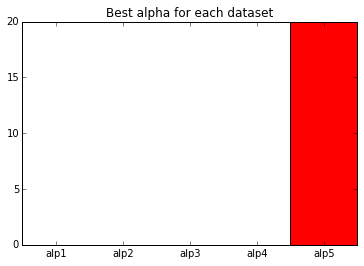

In [15]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = tr_data[:,:-1]
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = ts_data[:,:-1]
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_batch, params2)
    winners.append(alpha)
    beta,it = gd_batch(X_tr, y_tr, alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print '\n'

make_hist(winners,params2)

### Gradient descent batch for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006
Training error: 13.0062050605
Testing error: 65.2571301369
N° iterations: 7718
Beta: [ 39.12819425 -21.12211183  18.39155828 -16.19472306 -15.69925885
  40.12054606  16.08049095 -16.64772494  -5.87286996 -13.08148087
   5.18930831   9.8497999   23.09701364]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001
Training error: 16.3602257442
Testing error: 92.0230671423
N° iterations: 5765
Beta: [ 37.76010995 -23.91691135  19.33923593 -14.83153947 -11.34834923
  36.1198051   15.86964541 -12.49452803  -4.60486208 -10.83990299
   4.00286163   9.22876201  21.28151669]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001
Training error: 18.1457842322
Testing error: 115.610985266
N° iterations: 5754
Beta: [ 40.97

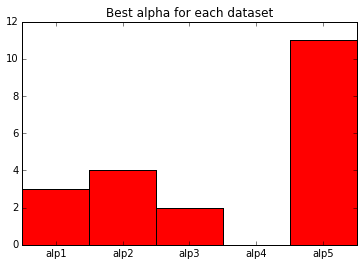

In [12]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = rescale(tr_data[:,:-1], 0., 1.)
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = rescale(ts_data[:,:-1], 0., 1.)
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_batch, params1)
    winners.append(alpha)
    beta,it = gd_batch(X_tr, y_tr, alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print '\n'

make_hist(winners,params1)

### Gradient descent batch for normalized data

###########################################################
Dataset: 0
Best alpha: 0.0002
Training error: 12.7266740348
Testing error: 38.4079585793
N° iterations: 1535
Beta: [ 42.22724     -4.04315611   4.26533185  -3.44623502  -3.92100029
   7.94102272   3.2702556   -4.1383568   -1.97993514  -3.21326375
   2.34548981   1.78377407   3.69012969]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0002
Training error: 16.0715344155
Testing error: 65.1941175822
N° iterations: 1897
Beta: [ 43.83778667  -4.66430519   4.32313969  -3.2124935   -3.14395908
   7.50054076   2.84675912  -3.45460573  -1.87703206  -2.3225976
   1.84182202   1.79539497   3.46750775]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001
Training error: 17.7788520385
Testing error: 18.2024811924
N° iterations: 485
Beta: [ 42.413

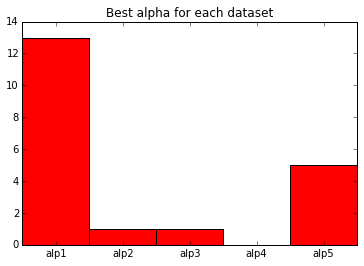

In [135]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = normalize(tr_data[:,:-1])
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = normalize(ts_data[:,:-1])
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_batch, params1)
    winners.append(alpha)
    beta,it = gd_batch(X_tr, y_tr, alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print '\n'

make_hist(winners,params1)

### Gradient descent online for raw data

###########################################################
Dataset: 0
Best alpha: 1e-07
Training error: 98.4684925188
Testing error: 121.542428251
N° iterations: 31061
Beta: [ 0.36439104  0.01975422  1.01170838 -1.16157244 -0.06125472  1.34702763
  2.67974276 -0.54338416  0.08381054 -0.08747182  0.7247942   0.21472848
  0.39881612]
###########################################################


###########################################################
Dataset: 1
Best alpha: 1e-07
Training error: 118.309573656
Testing error: 110.836416569
N° iterations: 19132
Beta: [ 0.25543655  0.00836076  0.72022014 -0.70526308 -0.03086521  0.59758163
  2.436482   -0.65458792  0.1253486  -0.10178878  0.48330924  0.14490576
  0.28704346]
###########################################################


###########################################################
Dataset: 2
Best alpha: 1e-07
Training error: 107.585127311
Testing error: 147.540167124
N° iterations: 19934
Beta: [ 0.21744495  0.02711775  0.737

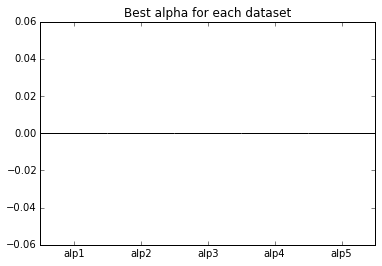

In [136]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = tr_data[:,:-1]
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = ts_data[:,:-1]
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_online, params2)
    beta,it = gd_online(X_tr, y_tr, alpha)
    winners.append(alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"
    
make_hist(winners,params2)

### Gradient descent online for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006
Training error: 13.0074188914
Testing error: 65.2775158068
N° iterations: 7716
Beta: [ 39.11586288 -21.13773613  18.38923592 -16.19356204 -15.68824135
  40.11271443  16.08682569 -16.63465575  -5.85040966 -13.0824112
   5.18382194   9.84443059  23.10824319]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001
Training error: 16.3629180412
Testing error: 93.6913520605
N° iterations: 5746
Beta: [ 37.80887213 -23.95322312  19.39327228 -14.79894787 -11.32872383
  36.1662421   15.88312906 -12.44975647  -4.65662256 -10.82793002
   4.01509246   9.21796703  21.2663034 ]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001
Training error: 18.1476046506
Testing error: 115.411791641
N° iterations: 5749
Beta: [ 40.948

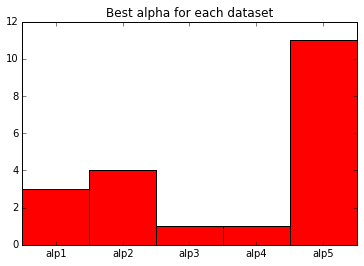

In [140]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = rescale(tr_data[:,:-1], 0., 1.)
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = rescale(ts_data[:,:-1], 0., 1.)
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_online, params1)
    beta,it = gd_online(X_tr, y_tr, alpha)
    winners.append(alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"
    
make_hist(winners,params1)

### Gradient descent online for normalized data

###########################################################
Dataset: 0
Best alpha: 0.0002
Training error: 12.7265440344
Testing error: 38.3704391845
N° iterations: 1534
Beta: [ 42.22651525  -4.04140807   4.26533568  -3.4473847   -3.91726341
   7.94397391   3.2690175   -4.13530417  -1.98042413  -3.21060613
   2.3436141    1.78623768   3.68635631]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0002
Training error: 16.0711580478
Testing error: 65.2908059333
N° iterations: 1891
Beta: [ 43.84338408  -4.66470646   4.32715625  -3.20692277  -3.14882485
   7.50409763   2.85182033  -3.44653668  -1.87895278  -2.32291694
   1.84388203   1.79465722   3.47214   ]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.0006
Training error: 17.7880949034
Testing error: 18.0041725612
N° iterations: 728
Beta: [ 42.4

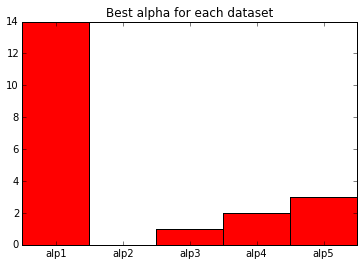

In [141]:
winners = list()

for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = normalize(tr_data[:,:-1])
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = normalize(ts_data[:,:-1])
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    alpha = find_best(X_tr, y_tr, gd_online, params1)
    beta,it = gd_online(X_tr, y_tr, alpha)
    winners.append(alpha)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Best alpha: {0}'.format(alpha)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"
    
make_hist(winners,params1)

### Newton-Raphson for raw data

In [123]:
for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = tr_data[:,:-1]
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = ts_data[:,:-1]
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    beta,it = nr_linear(X_tr, y_tr)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 29.8692128464
N° iterations: 2
Beta: [ 27.77312374  -0.19196441   3.64271996  -2.61978866  -0.04940511
   3.27558724   0.8950743   -0.94639251  -0.03448292  -0.13677948
   2.89862662  12.4397042   13.71043458]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 19.1213963039
N° iterations: 2
Beta: [ 32.77556027  -0.21889642   4.01031224  -2.79387988  -0.03884453
   3.10643719   0.67461777  -0.80667426  -0.03700155  -0.11417401
   2.23319673  12.31980684  12.62588456]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 13.1702299683
N° iterations: 2
Beta: [ 30.97809856  -0.22930608   4.12593951  -2.51735014  -0.04283795
   3.4

### Newton-Rhapson for rescaled data [0,1]

In [124]:
for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = rescale(tr_data[:,:-1], 0., 1.)
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = rescale(ts_data[:,:-1], 0., 1.)
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    beta,it = nr_linear(X_tr, y_tr)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 70.8230012379
N° iterations: 2
Beta: [ 37.68776506 -21.30804932  18.21359978 -15.71873198 -15.80963497
  45.85822131  16.11133741 -17.03506525 -10.86211949 -13.67794787
   5.79725325  12.4397042   24.27432442]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 105.300112485
N° iterations: 2
Beta: [ 36.81035813 -24.29750213  20.05156121 -13.96939941 -11.2649135
  43.49012072  14.84159095 -12.9067882  -11.98850316 -11.41740083
   4.46639345  12.31980684  22.35412861]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 139.177707921
N° iterations: 2
Beta: [ 39.98319337 -25.45297468  20.62969754 -15.10410084 -12.42300501
  47.71

### Newton-Raphson for normalized data

In [139]:
for i in xrange(20):
    #Loading dataset
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    ts_file = path1+'cereales-ts-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    ts_data = np.load(ts_file)
    
    X_tr = normalize(tr_data[:,:-1])
    y_tr = np.ascontiguousarray(tr_data[:,-1])
    #Adding column of 1's
    m,n = X_tr.shape
    X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)
    
    X_ts = normalize(ts_data[:,:-1])
    y_ts = np.ascontiguousarray(ts_data[:,-1])
    #Adding column of 1's
    m,n = X_ts.shape
    X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)
    
    beta,it = nr_linear(X_tr, y_tr)
    print "###########################################################"
    print "Dataset: {0}".format(i)
    print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
    print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
    print 'N° iterations: {0}'.format(it)
    print 'Beta: {0}'.format(beta)
    print "###########################################################"
    print "\n"

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 39.1167896725
N° iterations: 2
Beta: [ 42.22724     -3.99216233   4.26196505  -3.44486437  -3.93375017
   8.28671753   3.23536861  -4.20056151  -2.37742955  -3.2700182
   2.44555845   1.89445678   3.72993749]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 67.378076989
N° iterations: 2
Beta: [ 43.83778667  -4.60702487   4.40931759  -3.16661632  -3.13637015
   8.12721232   2.6937296   -3.56195787  -2.65364237  -2.37489256
   1.94115486   1.99611526   3.53901282]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 18.9190672901
N° iterations: 2
Beta: [ 42.41314667  -4.37995712   4.69576307  -3.21485752  -3.29190982
   8.568

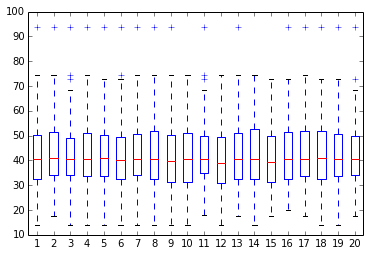

In [83]:
#generating boxplots for first dataset
data = np.empty((75,20))
for i in xrange(20):
    tr_file = path1+'cereales-tr-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    data[:,i] = tr_data[:,-1]
plt.boxplot(data)
plt.show()